In [1]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
%matplotlib inline


In [2]:
## Some utility functions
def percentToInt(percentString):
    return int(percentString.rstrip("%"))
def trueFalseToBinary(tfstring):
    return 1 if tfstring=='t' else '0'
def stringListToList(stringList):
    return ast.literal_eval(stringList)
def stringListToCount(stringList):
    return len(ast.literal_eval(stringList))

In [3]:
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"

reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

In [4]:
features_none_null = ["id","host_id","host_since","host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", "host_verifications",
                        # "host_has_profile_pic", "host_identity_verified",
                        # "neighbourhood_cleansed",
                        "latitude", "longitude",
                        "room_type", "accommodates", "amenities", "price", "minimum_nights", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable", 
                        ]
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"
reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

# reviews_data_path = "data/reviews.csv"
# listings_data_path = "data/listings.csv"
# calendar_data_path = "data/calendar.csv"
# reviews_data = pd.read_csv(reviews_data_path)
# listings_data = pd.read_csv(listings_data_path)
# calendar_data = pd.read_csv(calendar_data_path)

reviews_data = reviews_data.dropna()

df_none_null = listings_data.copy(deep = True)[features_none_null]

print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
print("after dropping rows with null columns: ", df_none_null.shape)


## most null columns - host_response_rate/accpetance rate, review_scores

reference_date = datetime.datetime(2021,7,12)
# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', ''))).astype('int32')


# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt).astype('int32')
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt).astype('int32')

# TODO host_response_time; arbitrary or one-hot
# df_none_null['host_response_time']= df_none_null['host_response_time'].map({
#     'within an hour':1, 'within a day':3, 'within a few hours':2,
#        'a few days or more':4
# })

host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary).astype('int32')
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount).astype('int32')
# # "host_has_profile_pic" tf to binary
# df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary).astype('int32')
# # "host_identity_verified",tf to binary
# df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary).astype('int32')

# TODO "neighbourhood_cleansed" or leave out - lat long enough

# "latitude" pass
# "longitude", pass

# "room_type" ['Entire home/apt'4 'Private room'2 'Shared room'1 'Hotel room'3]
df_none_null['room_type'] = df_none_null['room_type'].map(
                            {'Entire home/apt':4,
                                'Private room':2,
                                 'Shared room':1,
                                  'Hotel room':3})

# "accommodates", pass
#  "amenities", 
df_none_null['amenities'] = df_none_null['amenities'].map(stringListToCount).astype('int32')
# "price", pass

# TODO "minimum_nights", to categorical? 3 categories [short medium long?]
# df_none_null['minimum_nights'] = df_none_null['minimum_nights']

# "availability_30",
df_none_null['availability_30'] = df_none_null['availability_30']/30.0
# "availability_60",
df_none_null['availability_60'] = df_none_null['availability_60']/60.0
# "availability_90",
df_none_null['availability_90'] = df_none_null['availability_90']/90.0
# "availability_365", 
df_none_null['availability_365'] = df_none_null['availability_365']/365.0

# "number_of_reviews" pass,

# all pass
# "review_scores_rating", 
# "review_scores_accuracy",
# "review_scores_cleanliness",
# 	"review_scores_checkin",	
# "review_scores_communication",
# "review_scores_location",
# 	"review_scores_value",

# "instant_bookable", 
df_none_null['instant_bookable'] = df_none_null['instant_bookable'].map(trueFalseToBinary).astype('int32')

df_none_null = df_none_null.drop(['host_response_time', 'host_since'], axis=1)


before droppign rows with null columns:  (3043, 28)
after dropping rows with null columns:  (1678, 28)


# Engineer more VARIABLEs here

In [5]:
df_none_null = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 2)]

In [6]:
print(df_none_null['price'].describe())

count    1660.000000
mean      166.951205
std       120.817955
min         0.000000
25%        85.000000
50%       132.000000
75%       208.000000
max       750.000000
Name: price, dtype: float64


## Standarize features
### TODO: make certain binary features non-standardized

In [7]:
df = df_none_null.drop(['price', 'id','host_id'], axis=1)
df_normalized=(df - df.mean()) / df.std()
df_label = df_none_null['price']
X_train, X_test, y_train, y_test = train_test_split(df, df_label, test_size=0.1, random_state=101)



In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsClassifier(n_neighbors=2)
knn_model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

87.70037298487816

In [9]:
train_preds

array([200, 149,  79, ..., 135, 520, 120], dtype=int32)

In [10]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

103.0019007895731

# Neural Network


In [11]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# https://www.tensorflow.org/tutorials/keras/regression
# sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [12]:
# X_train, X_test, y_train, y_test 
df = df_none_null.drop(['id','host_id'], axis=1)
df_normalized=(df - df.mean()) / df.std()
df_label = df_normalized['price']
df_normalized=df_normalized.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_normalized, df_label, test_size=0.1, random_state=101)

nnn = 200
model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(1),
    ]
)
#@title 4. dense model compile
batch_size = 300
epochs = 200
op = keras.optimizers.SGD(learning_rate = 0.1)
# op = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=op, metrics=tf.keras.metrics.MeanSquaredError())

model.fit(X_train, y_train.to_numpy(), batch_size=batch_size, epochs=epochs, validation_split=0.1)



Epoch 1/200


2021-10-22 20:58:58.104218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-22 20:58:58.252847: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


5/5 [==============================] - 0s 37ms/step - loss: 0.9679 - mean_squared_error: 0.9679 - val_loss: 1.0515 - val_mean_squared_error: 1.0515
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.7533 - mean_squared_error: 0.7533 - val_loss: 1.2590 - val_mean_squared_error: 1.2590
Epoch 3/200
5/5 [==============================] - 0s 6ms/step - loss: 1.4826 - mean_squared_error: 1.4826 - val_loss: 1.0639 - val_mean_squared_error: 1.0639
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.8081 - mean_squared_error: 0.8081 - val_loss: 0.7379 - val_mean_squared_error: 0.7379
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.5424 - mean_squared_error: 0.5424 - val_loss: 0.5685 - val_mean_squared_error: 0.5685
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.7986 - mean_squared_error: 0.7986 - val_loss: 0.9361 - val_mean_squared_error: 0.9361
Epoch 7/200
5/5 [==============================] - 0s 6ms

In [13]:
model.evaluate(X_test, y_test, verbose=0)


[0.26244956254959106, 0.26244956254959106]

In [14]:
result = model.predict(X_test)
converted_rest = model.predict(X_test)*df_none_null['price'].std()+df_none_null['price'].mean()

difff= []
for i, j in enumerate(y_test*df_none_null['price'].std()+df_none_null['price'].mean()):
    difff.append(abs(converted_rest[i][0] - j))

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


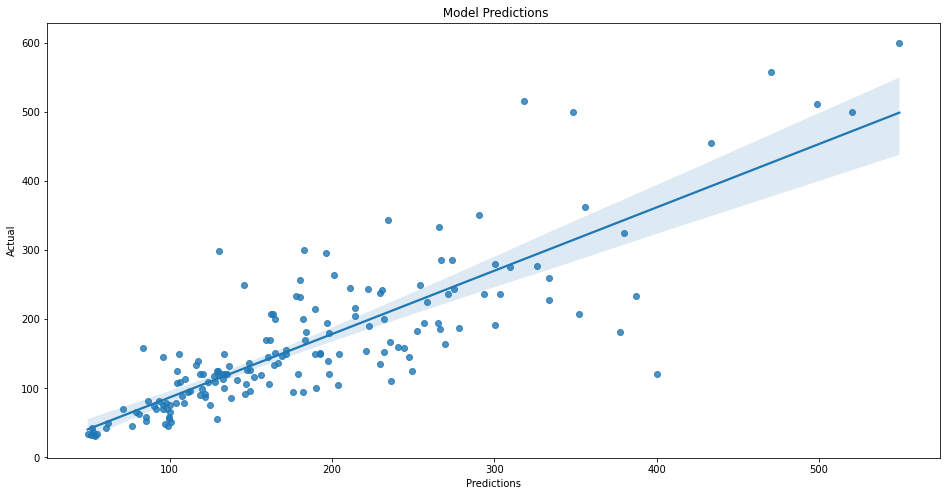

In [15]:
plt.figure(figsize=(16,8))
sns.regplot(converted_rest,y_test*df_none_null['price'].std()+df_none_null['price'].mean())
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title(" Model Predictions")
plt.grid(False)
plt.show()

In [16]:
np.array(difff).sum()

7464.606536865234

In [17]:
difff

[37.43475341796875,
 48.868003845214844,
 21.121734619140625,
 17.920265197753906,
 20.55187225341797,
 56.819091796875,
 105.77658081054688,
 20.6805419921875,
 55.21630859375,
 32.85711669921875,
 69.11306762695312,
 51.861907958984375,
 15.352813720703125,
 32.074432373046875,
 86.63247680664062,
 91.22686767578125,
 29.94390869140625,
 5.846466064453125,
 54.031494140625014,
 126.3587646484375,
 280.29132080078125,
 66.26654052734375,
 9.632171630859375,
 41.39201354980469,
 22.997909545898438,
 16.333351135253906,
 9.480133056640625,
 20.65338134765625,
 43.16636657714844,
 18.94830322265625,
 32.09281158447267,
 49.3431396484375,
 19.75555419921875,
 13.952140808105469,
 27.711280822753906,
 28.33904266357422,
 12.123870849609375,
 68.55697631835938,
 145.0887451171875,
 16.465225219726562,
 13.809417724609375,
 26.032363891601562,
 12.27117919921875,
 98.83306884765625,
 18.595123291015625,
 29.253219604492188,
 10.32119750976561,
 109.73529052734375,
 81.53884887695312,
 0.4413

In [18]:
converted_rest = model.predict(X_test)*df_none_null['price'].std()+df_none_null['price'].mean()

In [19]:
converted_rest

array([[156.43475 ],
       [ 96.868004],
       [433.87827 ],
       [ 80.920265],
       [104.44813 ],
       [293.8191  ],
       [269.77658 ],
       [ 53.680542],
       [380.2163  ],
       [222.85712 ],
       [252.11307 ],
       [180.13809 ],
       [160.35281 ],
       [232.07443 ],
       [244.63248 ],
       [278.22687 ],
       [166.94391 ],
       [ 86.846466],
       [ 99.031494],
       [236.35876 ],
       [400.29132 ],
       [303.26654 ],
       [129.63217 ],
       [192.39201 ],
       [168.99791 ],
       [112.33335 ],
       [214.48013 ],
       [147.65338 ],
       [163.83363 ],
       [267.0517  ],
       [ 77.09281 ],
       [326.34314 ],
       [ 95.755554],
       [ 78.95214 ],
       [ 85.71128 ],
       [ 98.33904 ],
       [149.12387 ],
       [235.55698 ],
       [352.08875 ],
       [ 52.465225],
       [164.80942 ],
       [104.032364],
       [498.72882 ],
       [196.16693 ],
       [ 51.595123],
       [141.25322 ],
       [ 52.321198],
       [234.2

# predicting availability based on price and other


In [20]:
# "availability_30",	"availability_60",	"availability_90","availability_365", 
# X_train, X_test, y_train, y_test 
df = df_none_null.drop(['id','host_id',"availability_60",	"availability_90","availability_365"], axis=1)
df_normalized=(df - df.mean()) / df.std()
df_label = df_normalized["availability_30"].map(lambda x:1.0-x)
df_normalized = df_normalized.drop(["availability_30"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(df_normalized, df_label, test_size=0.2, random_state=101)

nnn = 100
model = keras.Sequential(
    [
        keras.Input(shape=X_train.shape),
        layers.Dense(nnn,activation="relu"),
        layers.Dense(nnn,activation="relu"),

        layers.Dense(1),
    ]
)
#@title 4. dense model compile
batch_size = 300
epochs = 200
op = keras.optimizers.SGD(learning_rate = 0.1)
# op = keras.optimizers.Adam(learning_rate = 0.005)
model.compile(loss=keras.losses.MeanSquaredError(), optimizer=op, metrics=tf.keras.metrics.MeanSquaredError())

model.fit(X_train, y_train.to_numpy(), batch_size=batch_size, epochs=epochs, validation_split=0.2)



Epoch 1/200
4/4 [==============================] - 0s 31ms/step - loss: 5.3140 - mean_squared_error: 5.3140 - val_loss: 1.4218 - val_mean_squared_error: 1.4218
Epoch 2/200
4/4 [==============================] - 0s 6ms/step - loss: 1.3146 - mean_squared_error: 1.3146 - val_loss: 0.8860 - val_mean_squared_error: 0.8860
Epoch 3/200
4/4 [==============================] - 0s 6ms/step - loss: 1.0305 - mean_squared_error: 1.0305 - val_loss: 0.8169 - val_mean_squared_error: 0.8169
Epoch 4/200
4/4 [==============================] - 0s 6ms/step - loss: 0.9958 - mean_squared_error: 0.9958 - val_loss: 0.8039 - val_mean_squared_error: 0.8039
Epoch 5/200
4/4 [==============================] - 0s 6ms/step - loss: 0.9829 - mean_squared_error: 0.9829 - val_loss: 0.7948 - val_mean_squared_error: 0.7948
Epoch 6/200
4/4 [==============================] - 0s 6ms/step - loss: 0.9743 - mean_squared_error: 0.9743 - val_loss: 0.7884 - val_mean_squared_error: 0.7884
Epoch 7/200
4/4 [============================

In [21]:
# predicting availability based on PRICE, HOST ratings, and AMENITIES and LOCATION ONLY
# engineer additional features

# if subway/transportaion information is encoded in long/lat features, through clustering, may be able to use purely long/lat and no need for addtional engineering  

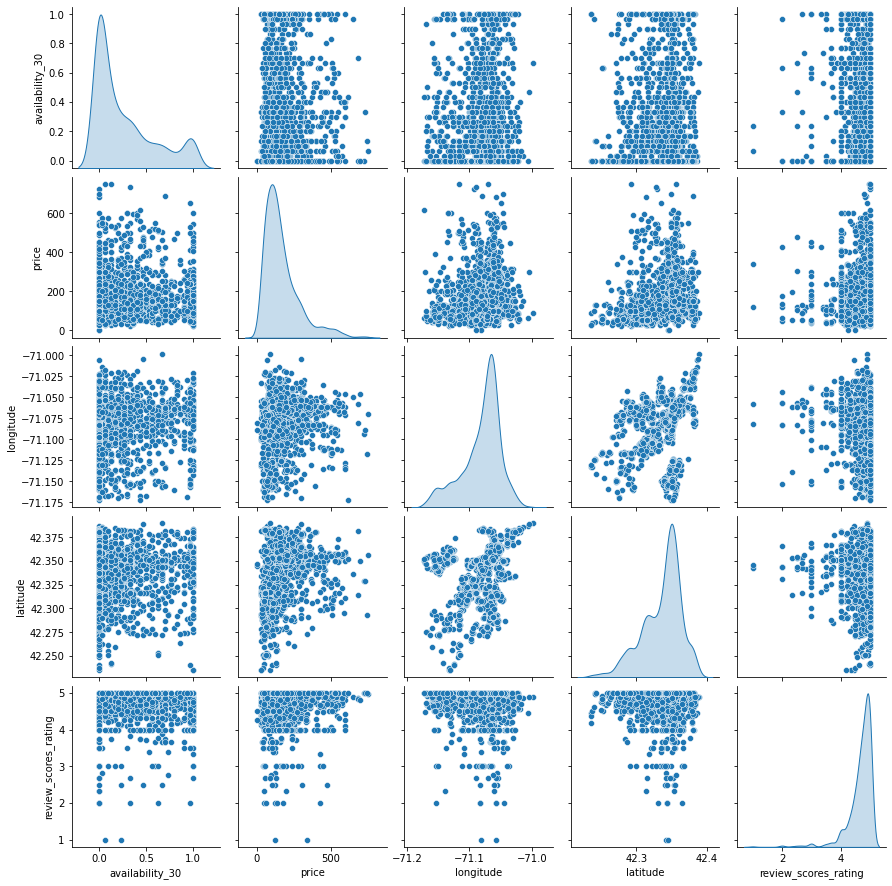

In [22]:
sns.pairplot(df_none_null[['availability_30', 'price', 'longitude', 'latitude','review_scores_rating']], diag_kind='kde')